In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rand
import numpy as np
import sys
import math
from student_utils import*
from utils import*
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#Graph drawing function:
def drawGraph(G):
    _=drawGraphStructure(G,20,5000)
    return


#draws a graph in the canvas of the notebook
def drawGraphStructure(G,kval,iters):
    pos = nx.spring_layout(G,k = kval/math.sqrt(len(G.nodes())),iterations=iters,scale =2)
    
    nx.draw(G, pos,node_size=1000,node_color = "w",font_size=12, width = 3)
    stupid = nx.draw_networkx_labels(G, pos)
    
    #dumb = nx.draw_networkx_edge_labels(G,pos)
    return pos


def drawAndLabelPathNodes(G,path,position,color,nsize):
    nx.draw_networkx_nodes(G,pos=position,nodelist=path,node_size=nsize,node_color =color)
    pos2 = {}
    for p in position:
        if p in path:
            pos2[p] = position[p]
    G2=nx.Graph()
    G2.add_nodes_from(list(set(path)))
    _=nx.draw_networkx_labels(G2, pos=pos2,nodelist=path, font_size=15,font_color="w")
    

def drawPathEdges(G,path,position,color,lineWidth):
    PathEdges = []
    for i in range(len(path) -1):
        PathEdges.append((path[i],path[i+1]))
    nx.draw_networkx_edges(G,pos=position,edgelist=PathEdges,edge_color=color,width=lineWidth)
        


#Graph drawing function with output drawn in.
def drawSolution(G,carPath,dropLocs):
    print(carPath)
    plt.figure(figsize=(20,20))
    position = drawGraphStructure(G,20,5000)
    
        
    drawAndLabelPathNodes(G,carPath,position,"b",2000)
    drawAndLabelPathNodes(G,[carPath[0]],position,"m",2000)
    drawPathEdges(G,carPath,position,"r",6)
    
    for dLoc in dropLocs:
        dropOffList = dropLocs[dLoc]
        for dest in dropOffList:
            path = nx.dijkstra_path(G,dLoc,dest)
            drawAndLabelPathNodes(G,path,position,"g",1000)
            drawAndLabelPathNodes(G,[path[0]],position,"y",1000)
            drawPathEdges(G,path,position,"c",2)
    plt.show()


#creates a graph from a list of locations and an edge matrix
def generateLabeledGraph(numLocs,listLocs,adjMatrix):
    #create a new graph
    G,msg = adjacency_matrix_to_graph(adjMatrix)
    #Create dictionary to relabel matrices:
    mapping = {}
    for i in range(len(listLocs)):
        mapping[i] = listLocs[i]
    nx.relabel_nodes(G,mapping,False)
    return G



In [3]:
#Output validating functions


def convertToFile(path, dropoff_mapping, path_to_file, list_locs):
    string = ''
    for node in path:
        string += list_locs[node] + ' '
    string = string.strip()
    string += '\n'

    dropoffNumber = len(dropoff_mapping.keys())
    string += str(dropoffNumber) + '\n'
    for dropoff in dropoff_mapping.keys():
        strDrop = list_locs[dropoff] + ' '
        for node in dropoff_mapping[dropoff]:
            strDrop += list_locs[node] + ' '
        strDrop = strDrop.strip()
        strDrop += '\n'
        string += strDrop
    utils.write_to_file(path_to_file, string)

In [4]:
g50 = "/Users/kristentamsil/Desktop/compSci/cs170/Project/inputs/50.in"
g100 = "/Users/kristentamsil/Desktop/compSci/cs170/Project/inputs/100.in"
g200 = "/Users/kristentamsil/Desktop/compSci/cs170/Project/inputs/200.in"

data50 = read_file(g50)

numLocs,numHouses,listLocs,listHouses,startLoc,adjMatrix = data_parser(data50)
G = generateLabeledGraph(numLocs,listLocs,adjMatrix)

In [5]:
#solver functions


#graph solver function
def solve(list_of_locations, list_of_homes, starting_car_location, adjacency_matrix, params=[]):
    """
    Write your algorithm here.
    Input:
        list_of_locations: A list of locations such that node i of the graph corresponds to name at index i of the list
        list_of_homes: A list of homes
        starting_car_location: The name of the starting location for the car
        adjacency_matrix: The adjacency matrix from the input file
    Output:
        A list of locations representing the car path
        A dictionary mapping drop-off location to a list of homes of TAs that got off at that particular location
        NOTE: both outputs should be in terms of indices not the names of the locations themselves
    """
    def pathLength(dest):
        return nx.dijkstra_path_length(G,currLoc,dest)
    
    home_indices = convert_locations_to_indices(list_of_homes,list_of_locations)
    start_index = convert_locations_to_indices([starting_car_location],list_of_locations)[0]
    dropoffs= {}
    G = adjacency_matrix_to_graph(adjacency_matrix)[0]
    currLoc = start_index
    
    for v in home_indices:
        print(str(v) + ", " + str(nx.dijkstra_path(G,currLoc, v)) + " d:" + str(nx.dijkstra_path_length(G,currLoc,v)))
    
    
    
    carPath = []
    while len(home_indices) > 0:
        #Find closest home
        closest = min(home_indices,key=pathLength)
        pathToClosest = nx.dijkstra_path(G,currLoc, closest)
        carPath.extend(pathToClosest)
        carPath.pop()
        currLoc = closest
        dropoffs[currLoc] = [currLoc]
        home_indices.remove(closest)
    carPath.extend(nx.dijkstra_path(G,currLoc,start_index))

    return carPath,dropoffs
    
    
    
    

In [6]:
#Visualizing the output
def output_and_visualize(listLocs,listHomes,startLoc,adj_matrix):
    path, dropoffs = solve(listLocs,listHomes,startLoc,adj_matrix)
    G = adjacency_matrix_to_graph(adj_matrix)[0]
    drawSolution(G,path,dropoffs)
    

8, [40, 23, 30, 37, 19, 8] d:14.76843
30, [40, 23, 30] d:5.07209
42, [40, 23, 30, 5, 42] d:12.62809
43, [40, 23, 30, 37, 36, 4, 43] d:21.072490000000002
24, [40, 24] d:7.0224
37, [40, 23, 30, 37] d:6.700810000000001
16, [40, 16] d:3.25739
14, [40, 25, 9, 13, 11, 14] d:13.88909
22, [40, 23, 30, 37, 19, 12, 22] d:16.75612
13, [40, 25, 9, 13] d:6.72729
[40, 16, 40, 23, 30, 37, 19, 8, 22, 21, 28, 6, 42, 6, 44, 9, 13, 11, 14, 11, 13, 9, 25, 40, 24, 23, 30, 37, 36, 4, 43, 4, 36, 37, 30, 23, 40]


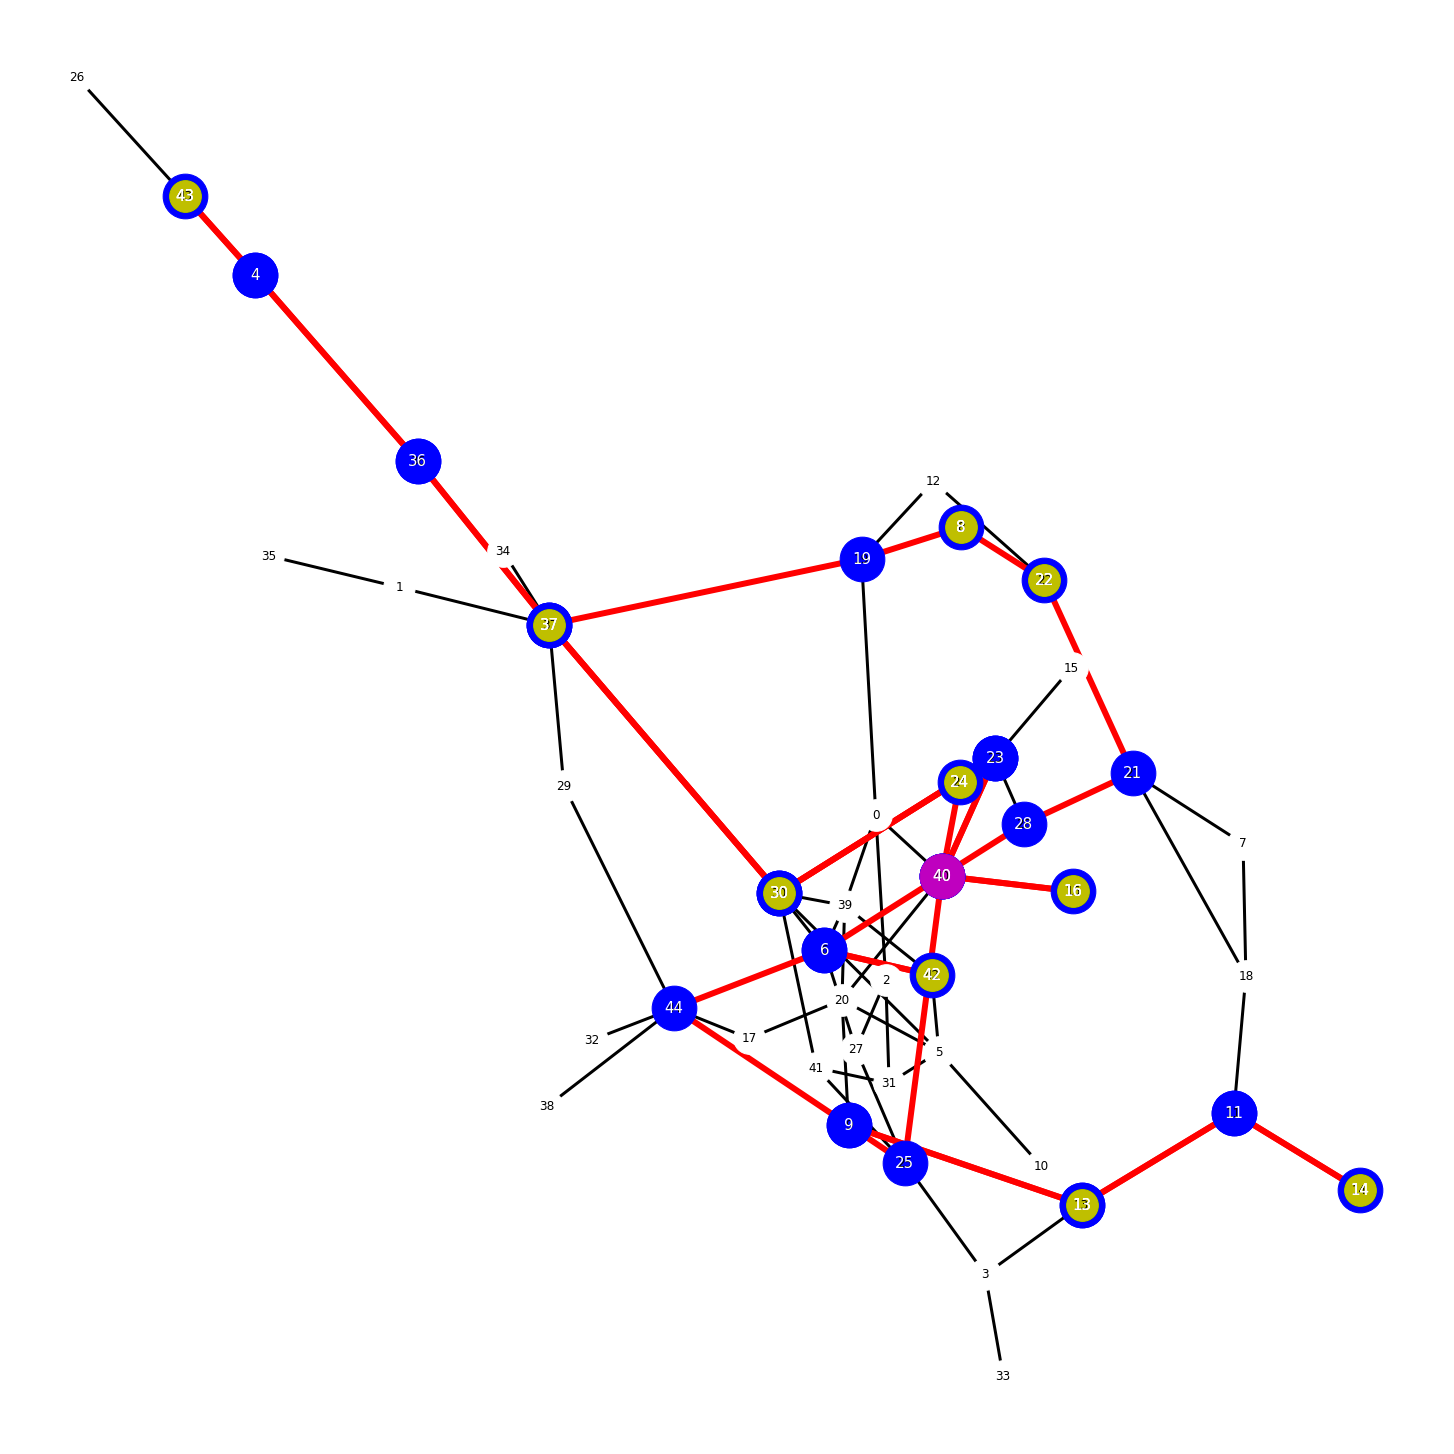

In [7]:
output_and_visualize(listLocs,listHouses,startLoc,adjMatrix)